<a href="https://colab.research.google.com/github/marcosilvaa/data_projects/blob/main/Crypto_Order_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exchange's Order Book

On financial markets, for every buy there's a sell going and every offers get compiled into an order book, each exchange have it's own order book for each stock or coin to be dealed.

Existem dois tipos de ordens, as ordens limite e ordens à mercado, e cada uma delas tem uma dinâmica diferente, mas abordaremos esta diferença ao longo deste notebook.

Para um trader ou até mesmo um investidor, é interessante acompanhar a mudança que ocorre no livro de ordens para se preparar para um possível movimento, muitas ordens acumuladas em um mesmo nível de preço criam a chamada Parede de Compra ou Parede de Venda, o que impede que o preço passe daquela faixa de negociação devido à enorme quantidade de ordens esperando para serem realizadas.

Vamos construir aqui um algoritimo que acesse os dados do livro de ordem diretamente das corretoras, e então transformar essas informações em forma gráfica para facilitar a interpretação dos dados.

In [30]:
# import packages 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# input crypto ticker
ticker = input('Insert crypto ticker: ').upper()

Insert crypto ticker: btcusdt


In [87]:
# Get request for BTCUSDT on Binance API
r = requests.get("https://api.binance.com/api/v3/depth",
                 params=dict(symbol=ticker))

results = r.json()


In [88]:
# Loading orders 
frames = {side: pd.DataFrame(data=results[side], columns =['price', 'quantity'],
                             dtype= float)
            for side in ['bids','asks']}

In [89]:
# concatenate DataFrames with bids and asks 
frames_list = [frames[side].assign(side=side) for side in frames]

data = pd.concat(frames_list, axis='index', ignore_index=True, sort=True)

In [90]:
# getting statistical summary with describe()
price_summary = data.groupby('side').price.describe()
#price_summary.to_markdown()
price_summary

,count,mean,std,min,25%,50%,75%,max
side,,,,,,,,
asks,100.0,16694.7223,1.393124,16692.37,16693.46,16694.90,16695.9500,16696.96
bids,100.0,16689.2186,1.531736,16686.95,16687.74,16689.11,16690.6925,16691.77


##The Top Of The Book

The Top of the Book is where the recent trades are found, between the highest bid and the lowest asking price. When there's a difference between these prices, it's called spread. The spread is how the exchanges make profit, you will always buy a little bit more than the mark price, as well you will sell it a little bit cheaper than the mark price.

In [91]:
bid = frames['bids'].price.max()
ask = frames['asks'].price.max()
spread = ask-bid

In [92]:
print(f'The ask price is {ask}')
print('')
print(f'The bid price is {bid}')
print('')
print(f'The spread is {spread}')

The ask price is 16696.96

The bid price is 16691.77

The spread is 5.18999999999869


With the Scatter plot we are able to see all the book entries, on X-Axis we can see the price and at the Y-Axis is the quantity of orders.

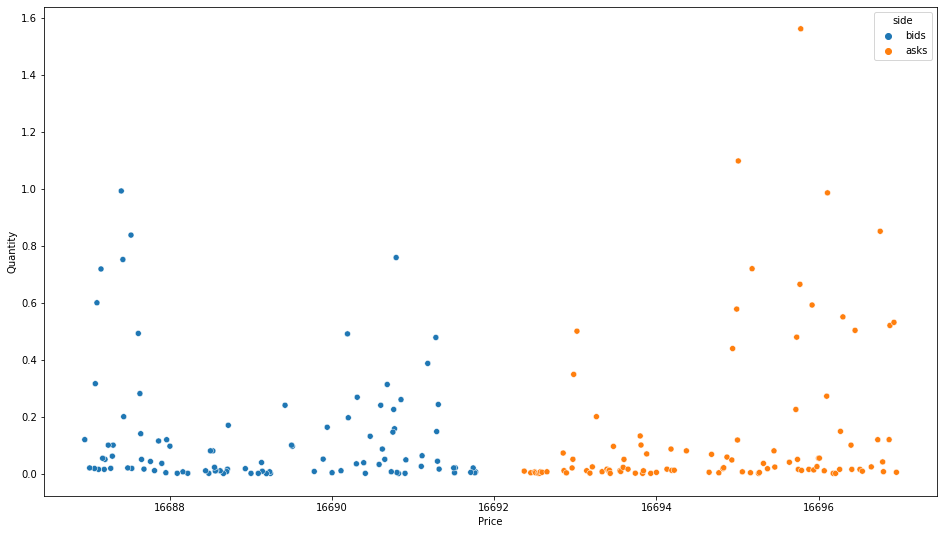

In [93]:
# Scatter plot for depth orders
fig, ax = plt.subplots(figsize=(16,9))

# hue means if the entry is an Ask or a Bid
sns.scatterplot(x="price", y="quantity", hue="side", data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

We can also visualize it on Histogram format.

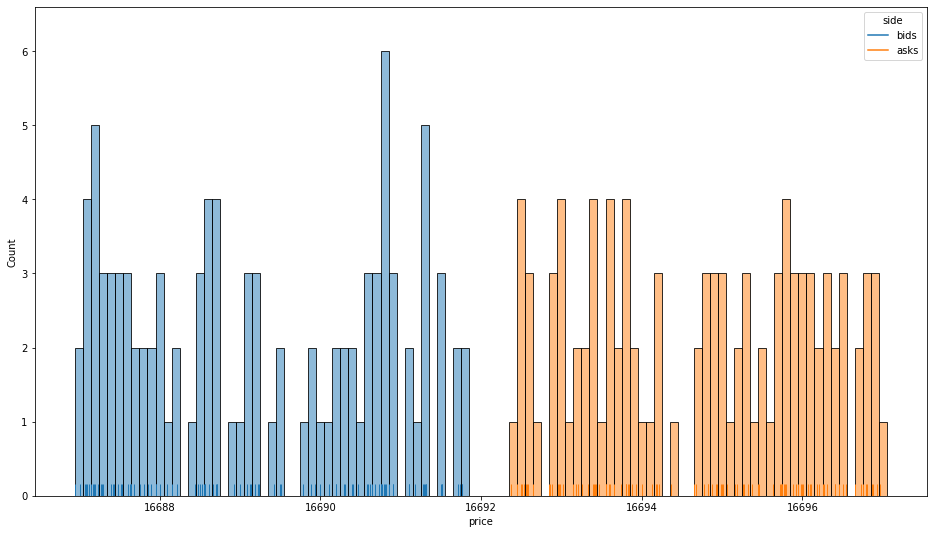

In [94]:
# Histogram plot
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(x='price', hue='side', binwidth=0.1, data=data, ax=ax)
sns.rugplot(x='price', hue='side', data=data, ax=ax)


plt.show()

There's one problem with this kind of visualization, it show us how much orders was placed at determined price, but, it can be a thousand of small orders that bring us a big histogram bar, as well it can be only one order, but with a greate amount and the histogram will print a small bar, even if that order is bigger than all of that thousands of small orders. 

To fix this, we have to plot this histogram a way differente, we can use a Weighted Histogram Plot.

Check below.

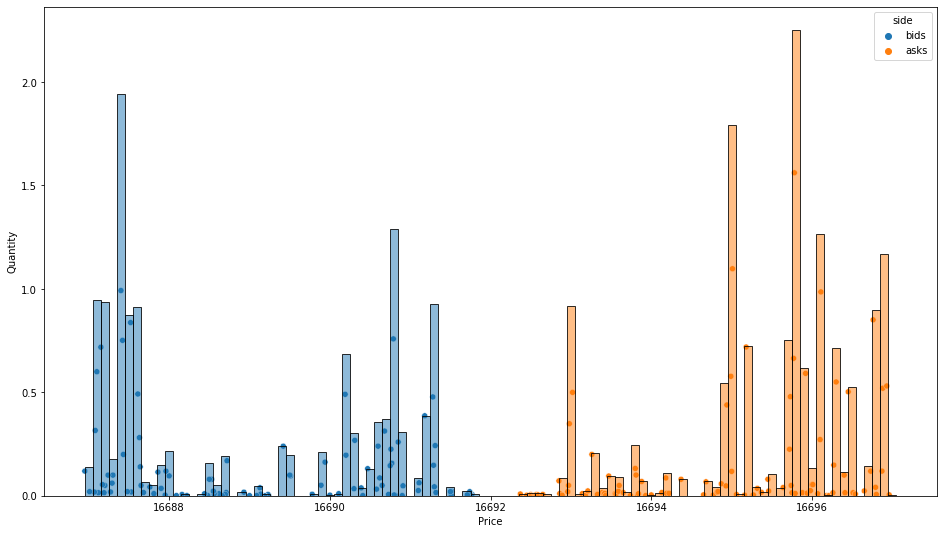

In [95]:
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(x='price', weights='quantity', hue='side', binwidth=0.1, data=data, ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)

ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
 
plt.show()

Now we have a differente distribuition that give us more insights about where are the Order's Wall. 

##Empirical distribution function

In statistics this function allow us to have the empirical measure of a sample, we are going to use this function to create a Depth Chart, that is a combination of two empirical cumulative distribution function. They are weighted and unnormalized ECDF plots.

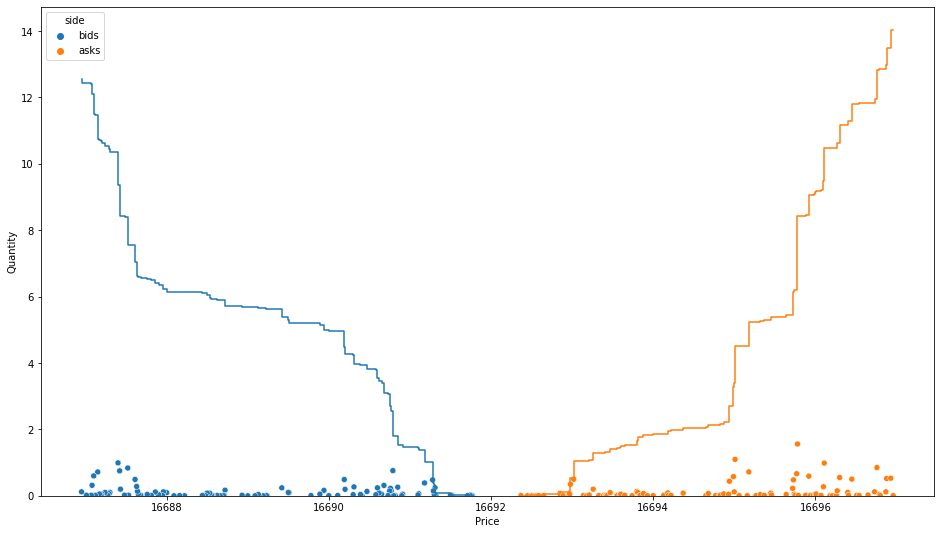

In [96]:
fig, ax = plt.subplots(figsize=(16,9))

sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()